# Advanced regression solution for Housing company 

### Solution can be divided into below sections : 

   * EDA
   * Data cleaning
   * Data Prepartion
   * Model building and evalutaion
   * Application of Ridge and Lasso models   

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [262]:
# reading the dataset
housing_data = pd.read_csv("train.csv", na_values="NAN")

# Let us check first few rows
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Let us start with EDA

In [263]:
# Check the dimensions of housing data
housing_data.shape

(1460, 81)

In [264]:
# Check details of all coloumns and their data types
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: xlabel='SalePrice', ylabel='Density'>

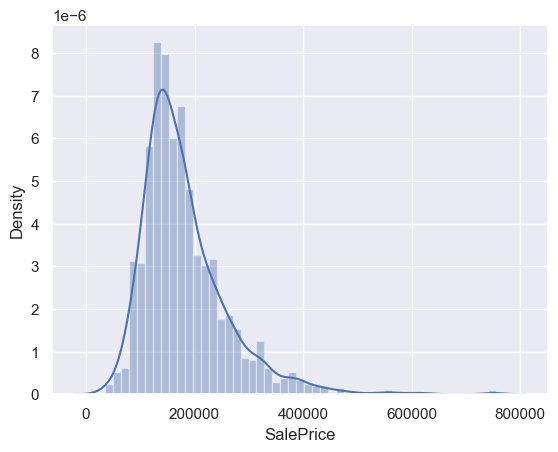

In [265]:
sns.distplot(housing_data['SalePrice'])

In [266]:
print("Skewness: %f" % housing_data['SalePrice'].skew())
print("Kurtosis: %f" % housing_data['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


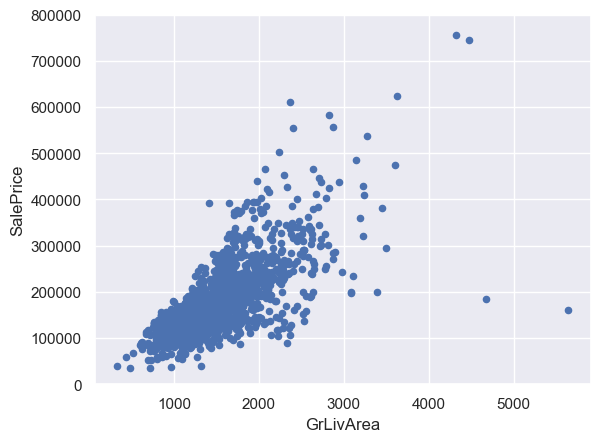

In [267]:
var = 'GrLivArea'
data = pd.concat([housing_data['SalePrice'], housing_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

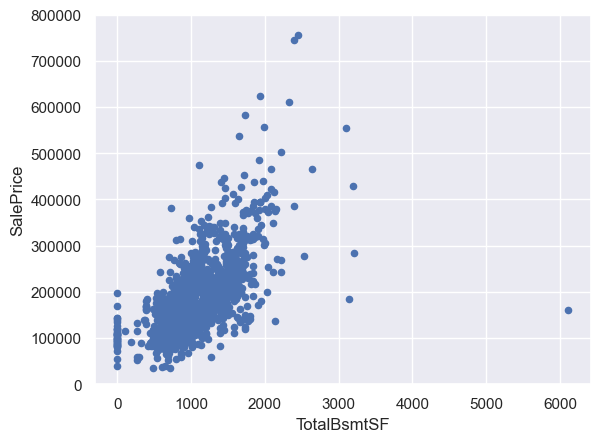

In [268]:
var = 'TotalBsmtSF'
data = pd.concat([housing_data['SalePrice'], housing_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

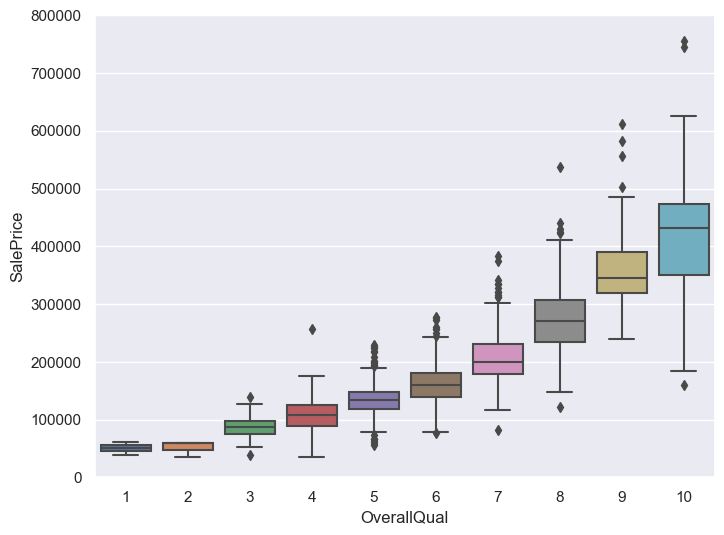

In [269]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([housing_data['SalePrice'], housing_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

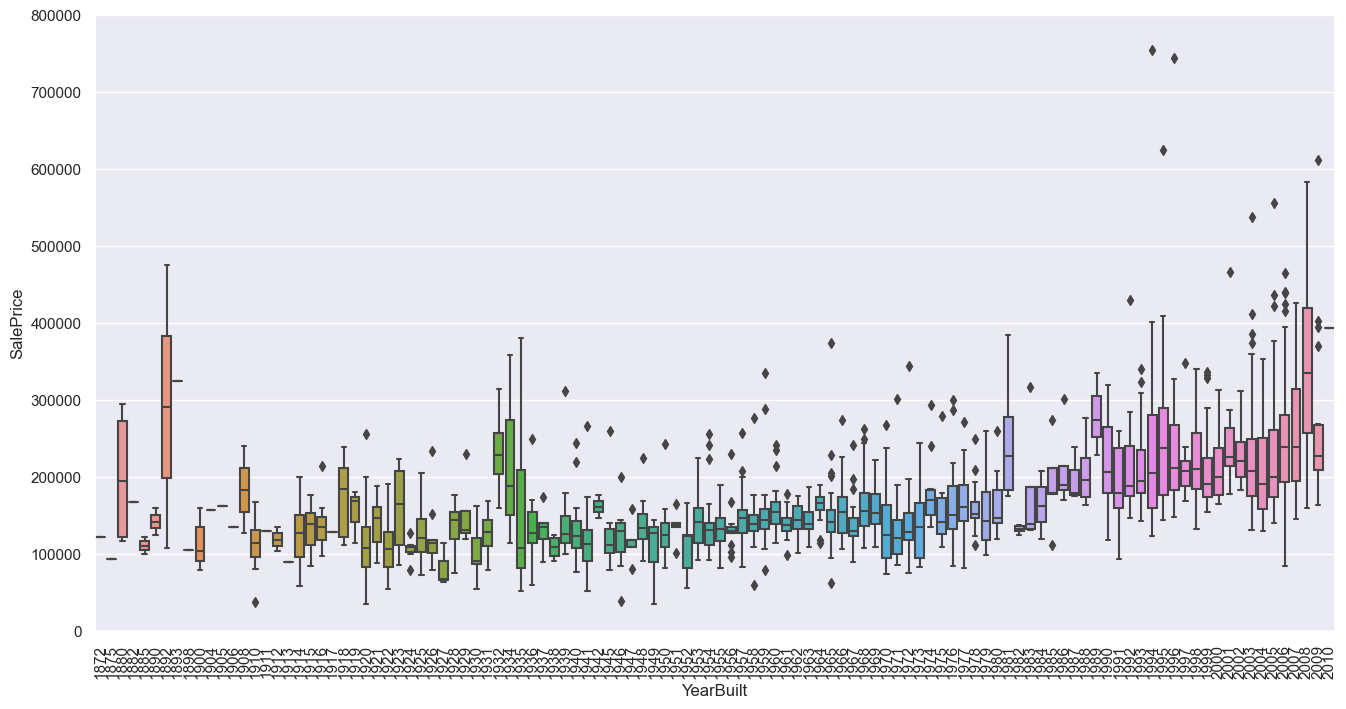

In [270]:
var = 'YearBuilt'
data = pd.concat([housing_data['SalePrice'], housing_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

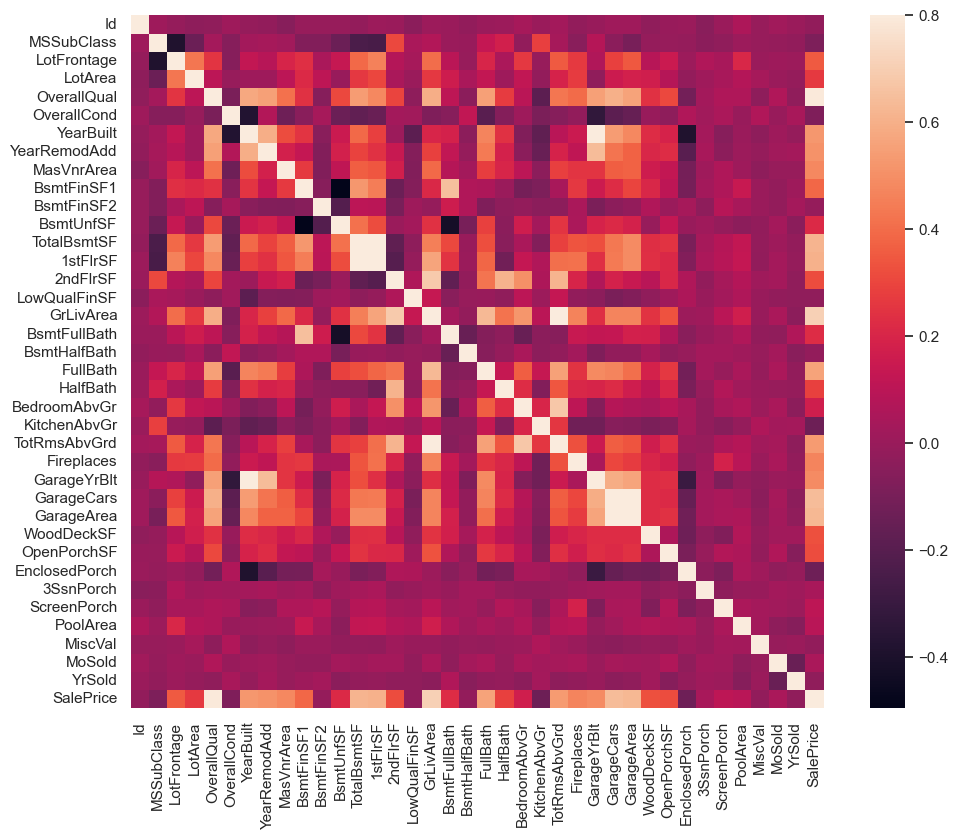

In [271]:
#correlation matrix
corrmat = housing_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

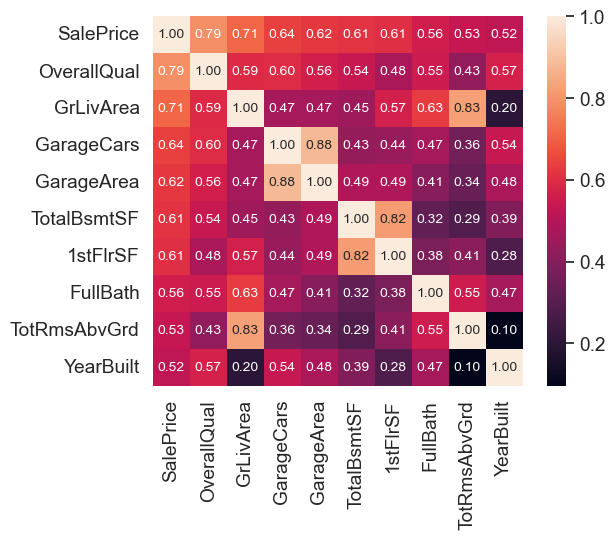

In [272]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(housing_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

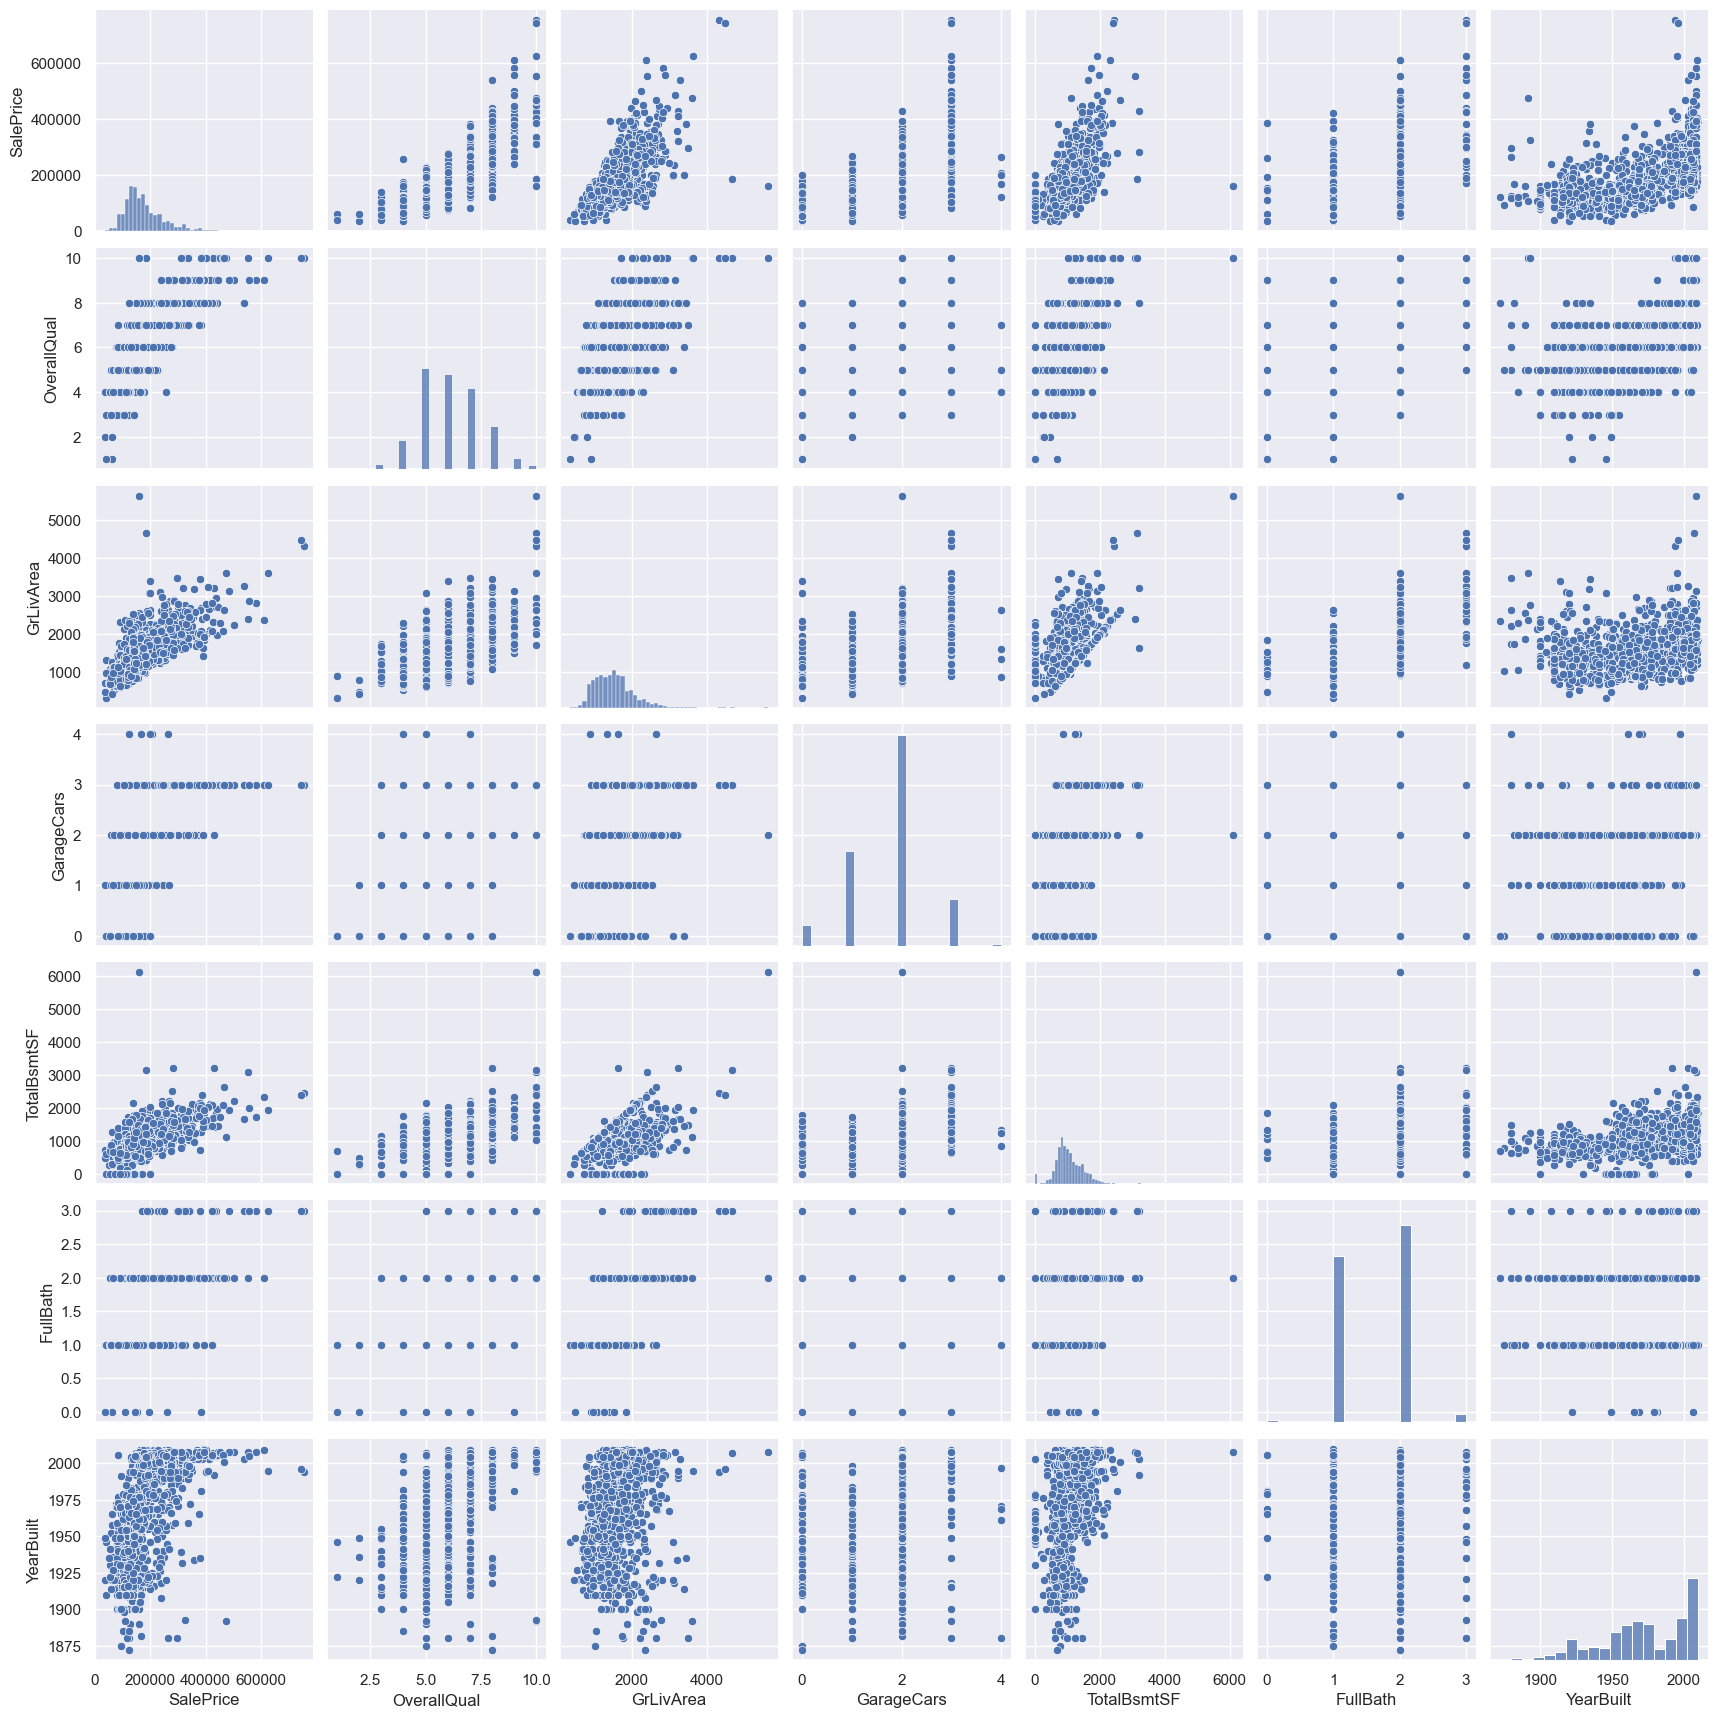

In [273]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(housing_data[cols], size = 2.5)
plt.show();

In [274]:
#missing data
total = housing_data.isnull().sum().sort_values(ascending=False)
percent = (housing_data.isnull().sum()/housing_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [275]:
null_has_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [276]:
for i in null_has_meaning:
    housing_data[i].fillna("None", inplace=True)


In [277]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [278]:
# checks for total and percent
total = housing_data.isnull().sum().sort_values(ascending=False)
percent = (housing_data.isnull().sum()/housing_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


In [279]:
# drop LotFrontage as it has too many null's
housing_data.drop("LotFrontage", axis=1, inplace=True)

In [280]:
#missing data
total = housing_data.isnull().sum().sort_values(ascending=False)
percent = (housing_data.isnull().sum()/housing_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


In [281]:
housing_data["GarageYrBlt"].fillna(housing_data["GarageYrBlt"].median(), inplace=True)
housing_data["MasVnrArea"].fillna(housing_data["MasVnrArea"].median(), inplace=True)
housing_data["MasVnrType"].fillna("None", inplace=True)

In [282]:
#missing data
total = housing_data.isnull().sum().sort_values(ascending=False)
percent = (housing_data.isnull().sum()/housing_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Electrical,1,0.000685
MSSubClass,0,0.000000
GarageYrBlt,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000


In [283]:
# there is one null value and we will drop 
housing_data.dropna(inplace=True)

In [284]:
# Let us double check if all is ok with missing values now 

In [285]:
#missing data
total = housing_data.isnull().sum().sort_values(ascending=False)
percent = (housing_data.isnull().sum()/housing_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


In [286]:
print(housing_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [287]:
# Let us determine data types for all remaining coloumns

types_train = housing_data.dtypes #type of each feature in data: int, float, object
num_train = types_train[(types_train == 'int64') | (types_train == float)] #numerical values are either type int or float
cat_train = types_train[types_train == object] #categorical values are type object

In [288]:
pd.DataFrame(types_train).reset_index().set_index(0).reset_index()[0].value_counts()

object     43
int64      35
float64     2
Name: 0, dtype: int64

In [289]:
# Let us divide categorical and numerical values

In [290]:
numerical_values_train = list(num_train.index)

In [291]:
print(numerical_values_train)

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [292]:
categorical_values_train = list(cat_train.index)
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [293]:
# creating vecotrs for data model

<Axes: xlabel='SalePrice', ylabel='Density'>

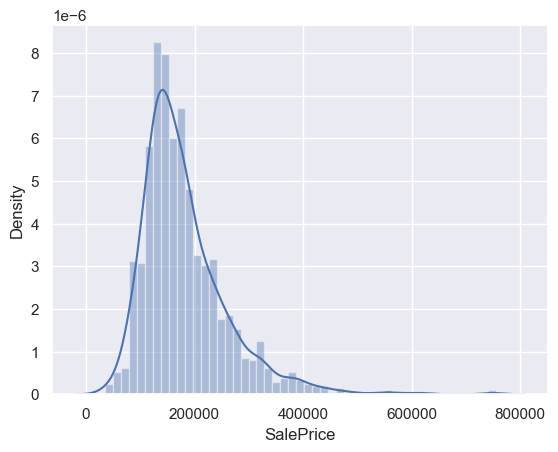

In [294]:
sns.distplot(housing_data["SalePrice"])

<Axes: xlabel='SalePrice', ylabel='Density'>

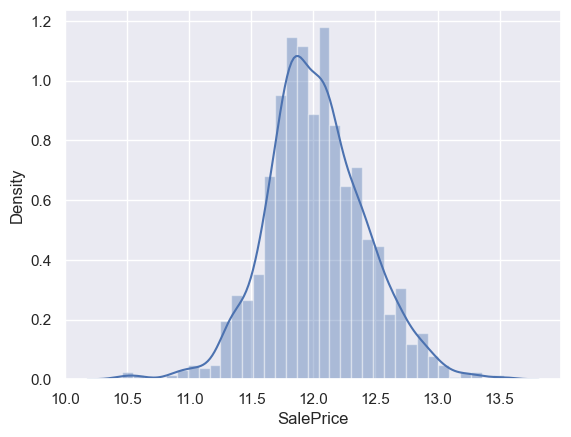

In [295]:
sns.distplot(np.log(housing_data["SalePrice"]))

In [296]:
#By transforming the prices, we can boost model performance.

In [297]:
housing_data["TransformedPrice"] = np.log(housing_data["SalePrice"])

In [298]:
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [299]:
for i in categorical_values_train:
    feature_set = set(housing_data[i])
    for j in feature_set:
        feature_list = list(feature_set)
        housing_data.loc[housing_data[i] == j, i] = feature_list.index(j)

In [300]:
housing_data.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TransformedPrice
0,1,60,0,8450,0,1,0,0,1,1,...,2,2,1,0,2,2008,2,2,208500,12.247694
1,2,20,0,9600,0,1,0,0,1,4,...,2,2,1,0,5,2007,2,2,181500,12.109011
2,3,60,0,11250,0,1,1,0,1,1,...,2,2,1,0,9,2008,2,2,223500,12.317167
3,4,70,0,9550,0,1,1,0,1,2,...,2,2,1,0,2,2006,2,0,140000,11.849398
4,5,60,0,14260,0,1,1,0,1,4,...,2,2,1,0,12,2008,2,2,250000,12.429216


In [301]:
# Model Building


In [302]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [303]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [304]:
X = housing_data.drop(["Id", "SalePrice", "TransformedPrice"], axis=1).values
y = housing_data["TransformedPrice"].values

In [305]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [306]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [307]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007379,0.000798,0.000998,6.312034e-04,0.0001,{'alpha': 0.0001},-0.083549,-0.095796,-0.102732,-0.094132,...,-0.094849,0.006347,1,-0.085055,-0.081274,-0.074332,-0.083607,-0.081985,-0.081251,0.003700
1,0.005983,0.000892,0.000998,6.309772e-04,0.001,{'alpha': 0.001},-0.094043,-0.101448,-0.104431,-0.093200,...,-0.097962,0.004328,2,-0.091164,-0.085299,-0.078478,-0.083975,-0.087043,-0.085192,0.004139
2,0.004588,0.000488,0.000997,2.132481e-07,0.01,{'alpha': 0.01},-0.096971,-0.103426,-0.106514,-0.096976,...,-0.099534,0.004692,3,-0.096864,-0.093541,-0.088788,-0.088662,-0.095497,-0.092670,0.003391
3,0.010771,0.001163,0.001396,4.884803e-04,0.05,{'alpha': 0.05},-0.101397,-0.115931,-0.119984,-0.117318,...,-0.111430,0.007850,4,-0.108202,-0.105269,-0.101593,-0.103067,-0.107471,-0.105120,0.002518
4,0.011968,0.002821,0.001197,3.990650e-04,0.1,{'alpha': 0.1},-0.104817,-0.123872,-0.127195,-0.122475,...,-0.117472,0.008859,8,-0.115887,-0.111486,-0.107125,-0.106748,-0.114608,-0.111171,0.003744


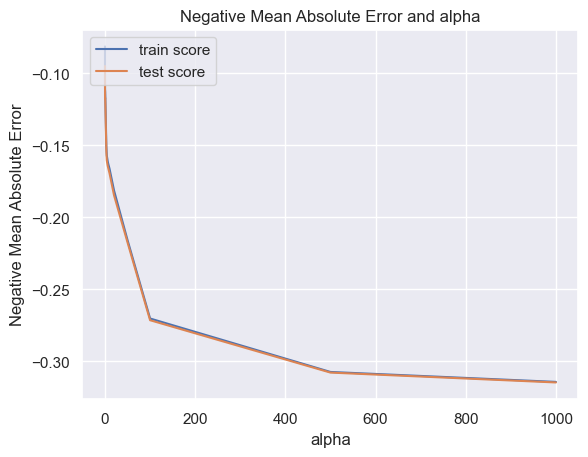

In [308]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [309]:
alpha = 50

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

Lasso(alpha=50)

In [310]:
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00,  4.02426915e-06, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.41724335e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.68173575e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [311]:
# lasso model parameters
model_parameters = list(lasso.coef_ )
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
#cols = X.columns
#cols = cols.insert(0, "constant")
#list(zip(cols, model_parameters))

In [312]:
# lasso regression
lm = Lasso(alpha=50)
lm.fit(X_train, y_train)

# prediction on the test set(Using R2)
y_train_pred = lm.predict(X_train)
#print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test)
#print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

In [313]:
from sklearn import metrics
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

RMSE : 0.26994008883976844


In [314]:
mod = list(zip(cols, model_parameters))

In [315]:
para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
para.head()

,Variable,Coeff
0,SalePrice,11.427
1,OverallQual,-0.000
2,GrLivArea,-0.000
3,GarageCars,0.000
4,TotalBsmtSF,-0.000


In [316]:
para = para.sort_values((['Coeff']), axis = 0, ascending = False)
para

,Variable,Coeff
0,SalePrice,11.427
1,OverallQual,-0.000
2,GrLivArea,-0.000
3,GarageCars,0.000
4,TotalBsmtSF,-0.000
5,FullBath,-0.000
6,YearBuilt,0.000


In [317]:
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

,Variable,Coeff
0,SalePrice,11.427


In [318]:
pred.shape

(1, 2)

In [319]:
Lassso_var = list(pred['Variable'])
print(Lassso_var)

['SalePrice']


In [320]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [321]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=5]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004387,0.000490,0.001795,3.986125e-04,0.0001,{'alpha': 0.0001},-0.082715,-0.095729,-0.102417,-0.084058,...,-0.092745,0.007940,2,-0.084757,-0.080959,-0.074122,-0.083553,-0.081789,-0.081036,0.003703
1,0.003191,0.001163,0.000998,4.156970e-07,0.001,{'alpha': 0.001},-0.082740,-0.095734,-0.102432,-0.083251,...,-0.092592,0.008119,1,-0.084769,-0.080966,-0.074125,-0.083575,-0.081793,-0.081046,0.003707
2,0.002194,0.000399,0.000998,1.784161e-07,0.01,{'alpha': 0.01},-0.082983,-0.095787,-0.102575,-0.091337,...,-0.094290,0.006745,3,-0.084885,-0.081043,-0.074165,-0.083624,-0.081875,-0.081118,0.003725
3,0.003191,0.000399,0.000998,2.336015e-07,0.05,{'alpha': 0.05},-0.083968,-0.095997,-0.103156,-0.093764,...,-0.095127,0.006399,4,-0.085358,-0.081372,-0.074451,-0.083641,-0.082247,-0.081414,0.003733
4,0.003794,0.000753,0.001193,4.012393e-04,0.1,{'alpha': 0.1},-0.084985,-0.096362,-0.103843,-0.094122,...,-0.095610,0.006217,5,-0.085863,-0.081765,-0.074839,-0.083643,-0.082745,-0.081771,0.003722


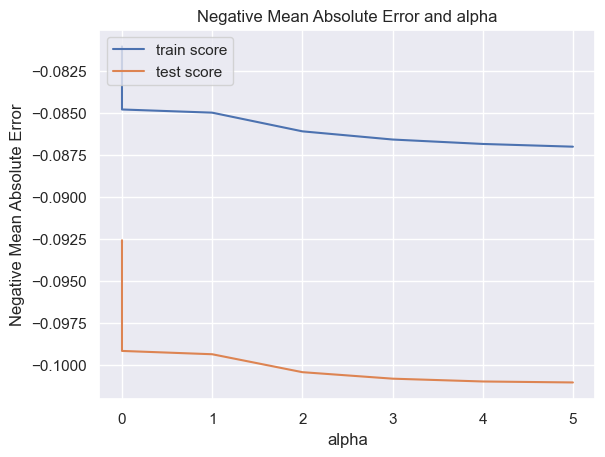

In [322]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [323]:
alpha = 2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-4.07261474e-04, -2.96658538e-02,  1.55316085e-06, -9.66297819e-02,
       -4.86026047e-02,  2.12822921e-04, -9.06157791e-03,  2.61735446e-02,
        7.57453665e-03, -3.97474389e-02,  1.34641031e-03, -1.36630375e-02,
        2.88536028e-02, -1.09270739e-02, -6.44100228e-03,  6.70375281e-02,
        4.44443582e-02,  1.54892458e-03,  1.28485679e-03, -6.42717668e-03,
        5.14820296e-02,  2.02147615e-03, -2.10287126e-03,  3.74453874e-03,
       -6.49118972e-07, -1.59174367e-02, -1.85174487e-02, -1.64538767e-02,
       -1.77293012e-02,  3.00408576e-02,  9.78298380e-03,  8.86806595e-03,
        2.72171656e-05, -1.24226491e-02,  3.87138032e-05,  9.90671003e-06,
        7.58376714e-05,  1.02169944e-02, -1.76113069e-02, -5.04568995e-02,
        1.90377780e-03,  4.33988150e-05,  7.17569741e-05,  5.99152778e-06,
        1.21147319e-04,  5.08521532e-02,  1.13894616e-02,  4.51247513e-02,
        1.89235451e-02,  2.84221929e-03, -5.47007510e-02, -9.36483534e-04,
        1.08550951e-02,  

In [324]:
# ridge model parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
#cols = X.columns
#cols = cols.insert(0, "constant")
#list(zip(cols, model_parameters))

In [325]:
# ridge regression
lm = Ridge(alpha=2)
lm.fit(X_train, y_train)

# predict
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9006957496796077
0.819744502955792


In [326]:
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

RMSE : 0.1647123762028052


In [327]:
mod_ridge = list(zip(cols, model_parameters))

In [328]:
paraRFE = pd.DataFrame(mod_ridge)
paraRFE.columns = ['Variable', 'Coeff']
res=paraRFE.sort_values(by=['Coeff'], ascending = False)
res.head(20)

,Variable,Coeff
0,SalePrice,20.454
1,OverallQual,-0.000
3,GarageCars,0.000
6,YearBuilt,0.000
2,GrLivArea,-0.030
5,FullBath,-0.049
4,TotalBsmtSF,-0.097


In [329]:
# Sort
paraRFE = paraRFE.sort_values((['Coeff']), axis = 0, ascending = False)
paraRFE

,Variable,Coeff
0,SalePrice,20.454
1,OverallQual,-0.000
3,GarageCars,0.000
6,YearBuilt,0.000
2,GrLivArea,-0.030
5,FullBath,-0.049
4,TotalBsmtSF,-0.097


In [330]:
predRFE = pd.DataFrame(paraRFE[(paraRFE['Coeff'] != 0)])
predRFE

,Variable,Coeff
0,SalePrice,20.454
2,GrLivArea,-0.030
5,FullBath,-0.049
4,TotalBsmtSF,-0.097


In [331]:
predRFE.shape

(4, 2)

### Observation:
##### It is advisable to use Lasso regression

### INFERENCE


#### Suggestions for Surprise Housing is to keep a check on these predictors affecting the price of the house.

#### The higher values of positive coeeficients suggest a high sale value.

#### Some of those features are:-
 |  Feature  |  Description  |
 |  ---  |  ---  |
 |  GrLivArea  |  Above grade (ground) living area square feet  |
 |  OverallQual  |  Rates the overall material and finish of the house  |
 |  OverallCond  |  Rates the overall condition of the house  |
 |  TotalBsmtSF  |  Total square feet of basement area  |
 |  GarageArea   |Size of garage in square feet  |
        
#### The higher values of negative coeeficients suggest a decrease in sale value.

#### Some of those features are:-
PropAge and MSSubClass

  
#### When the market value of the property is lower than the Predicted Sale Price, its the time to buy.